In [1]:

import numpy as np
import pandas as pd
# Example matrix
matrix_size = 100
data = pd.read_parquet('/Users/dima/Documents/dpp4nlp/data/encoded_texts.parquet', engine='pyarrow')

In [4]:
embs = np.array(data['article_embedding'].to_list())

In [27]:
from diffprivlib.mechanisms import Exponential

def similarity(u, v):
    dot_product_uv = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    similarity_uv = dot_product_uv / (norm_u * norm_v)
    return similarity_uv

def kernel_matrix(data):
    n = len(data)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = similarity(data[i], data[j])
    return K

def select_eigenvectors(eigenvalues, eigenvectors, n, dp=True):
    selected_eigenvalues = []
    selected_eigenvectors = []
    alpha = 1
    if dp:
        eps = np.abs(np.log(n) - np.log(n - 1))        
    for eigenvalue, eigenvector in zip(eigenvalues, eigenvectors.T):
        if dp:
            # bin_exp actually decides only on the coin flip, the probability itself is unaffected
            bin_mech = Exponential(epsilon=2*eps, sensitivity=eps, utility=[0, eigenvalue])
            # now we actually calculate the prob
            prob = np.exp(alpha * np.log(eigenvalue)) / (np.exp(alpha * np.log(eigenvalue)) + 1)
            prob = prob * bin_mech.randomise()
            if np.random.rand() < prob:
                selected_eigenvalues.append(eigenvalue)
                selected_eigenvectors.append(eigenvector)
        else:
            prob = eigenvalue / (eigenvalue + 1)
            if np.random.rand() < prob:
                selected_eigenvalues.append(eigenvalue)
                selected_eigenvectors.append(eigenvector)
    
    return np.array(selected_eigenvalues), np.array(selected_eigenvectors).T


def select_items(eigenvectors, items, idxs=True):
    subset_Y = []

    for eigenvector in eigenvectors.T:
        # Calculate squared magnitude of components
        squared_magnitude = np.square(np.abs(eigenvector))

        # Normalize squared magnitudes to probabilities
        # probabilities = squared_magnitude / np.sum(squared_magnitude)

        # Select an item based on probabilities
        selected_index = np.random.choice(len(eigenvector), p=squared_magnitude)
        if idxs:
            subset_Y.append(selected_index)
        else:
            selected_item = items[selected_index]
            subset_Y.append(selected_item)
    
    return subset_Y

def probability_of_selection(K, Y):
    # Extract submatrix Ky
    Ky = K[Y][:, Y]
    
    # Compute determinants
    det_Ky = np.linalg.det(Ky)
    det_K_plus_I = np.linalg.det(K + np.eye(K.shape[0]))  # Adding identity matrix
    
    # Compute probability of selection
    probability = det_Ky / det_K_plus_I
    
    return probability


In [5]:
K = kernel_matrix(embs)
eigenvalues, eigenvectors = np.linalg.eig(K)


In [28]:
selected_val, selected_vec = select_eigenvectors(eigenvalues, eigenvectors, dp=True, n=len(data))

/var/folders/br/gc6vlxzj7kb1h9qj5qzxxxlw0000gn/T/ipykernel_16098/3219889690.py:31: RuntimeWarning: invalid value encountered in log
  prob = np.exp(alpha * np.log(eigenvalue)) / (np.exp(alpha * np.log(eigenvalue)) + 1)


In [29]:
final_vecs = select_items(selected_vec, data)

In [30]:
len(final_vecs)

213

In [9]:
# import pandas as pd

# ds = pd.read_csv("/Users/dima/Documents/dpp4nlp/data/News_Category_Dataset_v3_50.csv")

for j in final_vecs:
    print(data.iloc[j]["category"])


CULTURE & ARTS
COMEDY
WEDDINGS
THE WORLDPOST
HOME & LIVING
FOOD & DRINK
TECH
WORLD NEWS
WEIRD NEWS
EDUCATION
IMPACT
ENTERTAINMENT
DIVORCE
ENTERTAINMENT
WORLD NEWS
HOME & LIVING
BUSINESS
POLITICS
ENTERTAINMENT
GREEN
POLITICS
ENTERTAINMENT
BLACK VOICES
STYLE & BEAUTY
POLITICS
STYLE
POLITICS
WELLNESS
POLITICS
HEALTHY LIVING
STYLE & BEAUTY
DIVORCE
MEDIA
HOME & LIVING
PARENTING
DIVORCE
QUEER VOICES
U.S. NEWS
WELLNESS
WOMEN
WELLNESS
POLITICS
WELLNESS
MONEY
ENVIRONMENT
WELLNESS
ARTS & CULTURE
CRIME
TRAVEL
POLITICS
ENTERTAINMENT
TRAVEL
QUEER VOICES
POLITICS
POLITICS
QUEER VOICES
QUEER VOICES
QUEER VOICES
MONEY
COMEDY
WOMEN
FOOD & DRINK
ENTERTAINMENT
WELLNESS
TRAVEL
IMPACT
HEALTHY LIVING
TRAVEL
WORLD NEWS
PARENTING
WEIRD NEWS
SPORTS
TASTE
FOOD & DRINK
ARTS
POLITICS
PARENTS
MEDIA
SPORTS
ENTERTAINMENT
WELLNESS
BLACK VOICES
MEDIA
PARENTS
MEDIA
ENTERTAINMENT
TECH
WELLNESS
WELLNESS
TASTE
WELLNESS
HOME & LIVING
POLITICS
CRIME
WEIRD NEWS
WEIRD NEWS
BUSINESS
PARENTING
POLITICS
BUSINESS
WEDDINGS
STYLE &

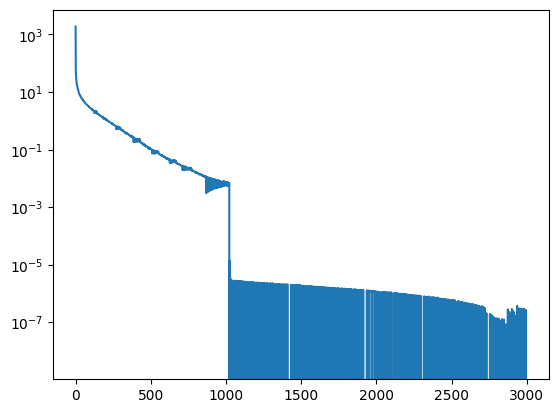

In [10]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(eigenvalues)